# WeatherPy

*  In the temperature chart below, it illustrates that, generally, places closer to the Equator (lower latitudes) have relatively higher temperatures than places farther from the Equator (higher latitudes).

*  In the humidity chart below, it illustrates that the higher the latitude the more likely the higher the humidity. What does this mean?  I researched it and found that a reading of 100 percent relative humidity means that the air is totally saturated with water vapor and cannot hold any more, creating the possibility of rain.  The chart shows that between 50-75 latitude, % humidity is mostly between 80% to 100%.

*  In the Wind Speed chart below, it illustrates that the wind speed does is not affected by the change in latitude.  Wind speed is about 0 - 20 mph in all latitudes. 




In [1]:
# longtiude (-180 - 180)
# latitude (-90 - 90)

# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
import time
import random
import sys
import math
from citipy import citipy
from datetime import datetime


# flag to run from file created or run from a new generated random numbers
#  True:  to run it from the csv file created
#  False: to create latitude and Longtitude file and call the api
runFromFile = True

outpath = "Resources"
keyfile = '%s/Keys' % (outpath)
latlong_filename = '%s/Locations' % (outpath)
reportDate = datetime.today()
logfilename = "%s/weatherpy_%s" % (outpath, datetime.strftime(reportDate,'%Y%m%d.%f'))


In [2]:
def generate_random_data(radius, num_rows):
    counter = 0
    while counter < num_rows:
        lat = float(np.random.randint(-90, 90)) + np.random.randint(-90, 90)/radius
        lon = float(np.random.randint(-180, 180)) + np.random.randint(-180, 180)/radius    

        # find city name
        city = citipy.nearest_city(lat, lon)
        if city.city_name in City:
#             print("Duplicate:  Will Bypass %s" % city.city_name)
            continue
        else:
            counter += 1 
            City.append (city.city_name)
            Lon.append (lon)
            Lat.append (lat)


## Generate City List

In [3]:
if not runFromFile:     
    nbrRows = 700
    # Earths radius
    # longtiude (-180 - 180)
    # latitude (-90 - 90)
    earthRadius = 3959
#     lonlat = []
    City = []
    Lon = []
    Lat = []
    
    print("Creating file: %s.csv" % latlong_filename)
    
    generate_random_data(earthRadius, nbrRows)
    locations_df = pd.DataFrame(
    {'City': City,
     'Lat': Lat,
     'Long': Lon
    }, columns=['City','Lat', 'Long'])

    #  create the city file list 
    locations_df.to_csv("%s.csv" % latlong_filename, index=False)
    locations_df

Creating file: Resources/Locations.csv


## Perform API Calls

In [4]:
if not runFromFile: 
    # Create blank columns for necessary fields
    locations_df["City Id"] = ""
    locations_df["Date"] = ""
    locations_df["Country"] = ""
    locations_df["Max Temp"] = ""
    locations_df["Humidity"] = ""
    locations_df["Cloudiness"] = ""
    locations_df["Wind Speed"] = ""


    # Counters
    row_count = 0
    rowsError = 0
    rowsRetrieved = 0
    
    # get key
    key_pd = pd.read_csv("%s.csv" % (keyfile))
    wkey = key_pd[key_pd['Name']== 'wkey']['key'].max().strip()
#     print(wkey)
    
    fw = open("%s.log" % (logfilename), 'w', newline='\n')

    print("----------------------------------")    
    print("Data Retrieval Start")     
    print("----------------------------------")
    
    fw.write("----------------------------------\n")    
    fw.write("Data Retrieval Start\n")     
    fw.write("----------------------------------\n") 

    # Loop through and grab the lat/lng using Google maps
    for index, row in locations_df.iterrows():    
        # Create endpoint URL
        target_url = "https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=%s&q=%s" % (wkey, row['City'])
    #     print(target_url)
        # Retrieve response in json format
        city_weather = req.get(target_url).json()

        row_count += 1
        try:        
            # Printing log to ensure loop is working correctly
            # get id and name of city
            print("%s Now retrieving city # %s: %s" % (row_count, city_weather['id'], row['City'] ))
            print("%s\n" % target_url)           
            
            fw.write("%s Now retrieving city # %s: %s\n" % (row_count, city_weather['id'], row['City'] ))
            fw.write("%s\n" % target_url)
            
            locations_df.set_value(index,"City Id", city_weather['id'])
            locations_df.set_value(index,"Date", city_weather['dt'])
            locations_df.set_value(index,"Country", city_weather['sys']['country'])
            locations_df.set_value(index,"Max Temp", city_weather['main']['temp'])
            locations_df.set_value(index,"Humidity", city_weather['main']['humidity'])
            locations_df.set_value(index,"Cloudiness", city_weather['clouds']['all'])
            locations_df.set_value(index,"Wind Speed", city_weather['wind']['speed'])
            rowsRetrieved += 1
        except:
            print("%s ****** Missing City %s" % (row_count, row['City']))
            rowsError += 1

    print("----------------------------------")    
    print("Data Retrieval Complete")
    print("Total records retrieved: %s" % rowsRetrieved)
    print("Total records in error: %s" % rowsError)
    print("----------------------------------")
    
    fw.write("----------------------------------\n")    
    fw.write("Data Retrieval Complete\n")
    fw.write("Total records retrieved: %s\n" % rowsRetrieved)
    fw.write("Total records in error: %s\n" % rowsError)
    fw.write("----------------------------------\n")
    fw.close()

    #  create the csv that is the one used for this project
    locations_df.to_csv("%s_final.csv" % latlong_filename, index=False)
else:
    # read the random latitude and longtitude
    print("Reading from file: %s_final.csv" % (latlong_filename))
    locations_pd = pd.read_csv("%s_final.csv" % (latlong_filename))
    locations_df = pd.DataFrame(locations_pd)
    
locations_df.head()


----------------------------------
Data Retrieval Start
----------------------------------
1 Now retrieving city # 360464: el wasta
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=el wasta

2 Now retrieving city # 3430863: mar del plata
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mar del plata

3 Now retrieving city # 2075265: busselton
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=busselton

4 Now retrieving city # 5975004: high level
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=high level

5 Now retrieving city # 292223: dibaya
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=dibaya

6 Now retrieving city # 3369157: cape town
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d1

54 Now retrieving city # 2173125: burnie
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=burnie

55 Now retrieving city # 1078553: ampanihy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ampanihy

56 Now retrieving city # 3452483: prado
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=prado

57 Now retrieving city # 3526662: izamal
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=izamal

58 Now retrieving city # 1493044: sarapulka
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=sarapulka

59 Now retrieving city # 935215: saint-philippe
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=saint-philippe

60 Now retrieving city # 493160: kizilskoye
https://api.ope

108 Now retrieving city # 3985710: cabo san lucas
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=cabo san lucas

109 Now retrieving city # 1855342: nishihara
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=nishihara

110 Now retrieving city # 3874787: punta arenas
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=punta arenas

111 Now retrieving city # 3418910: upernavik
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=upernavik

112 Now retrieving city # 4031574: provideniya
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=provideniya

113 Now retrieving city # 1855891: nakamura
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=nakamura

114 Now retrieving cit

161 Now retrieving city # 1800657: mentougou
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mentougou

162 Now retrieving city # 5882953: aklavik
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=aklavik

163 Now retrieving city # 5866063: kenai
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=kenai

164 Now retrieving city # 4035715: avarua
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=avarua

165 Now retrieving city # 1265150: lalpur
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=lalpur

166 Now retrieving city # 876123: lumeje
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=lumeje

167 Now retrieving city # 1257326: haibowan
https://api.openweathermap.

213 Now retrieving city # 7020913: vaitupu
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=vaitupu

214 Now retrieving city # 3347019: namibe
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=namibe

215 Now retrieving city # 2508813: adrar
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=adrar

216 Now retrieving city # 4428667: gulfport
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=gulfport

217 Now retrieving city # 2136150: luganville
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=luganville

218 Now retrieving city # 1175712: jiwani
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=jiwani

219 Now retrieving city # 1649150: bengkulu
https://api.openweat

265 Now retrieving city # 3421719: narsaq
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=narsaq

266 Now retrieving city # 692829: mys shmidta
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mys shmidta

267 Now retrieving city # 3836669: san rafael
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=san rafael

268 Now retrieving city # 1153669: chiang rai
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=chiang rai

269 Now retrieving city # 2263905: ribeira brava
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ribeira brava

270 Now retrieving city # 245669: adre
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=adre

271 Now retrieving city # 3466704: castro


317 Now retrieving city # 8185303: ambulu
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ambulu

318 Now retrieving city # 2738381: lata
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=lata

319 Now retrieving city # 527321: mezen
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mezen

320 Now retrieving city # 2643044: margate
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=margate

321 Now retrieving city # 2017155: saskylakh
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=saskylakh

322 Now retrieving city # 1106677: bambous virieux
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=bambous virieux

323 Now retrieving city # 1792916: tianpeng
https://api.o

370 Now retrieving city # 3354898: okahandja
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=okahandja

371 Now retrieving city # 1263900: mandapam
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mandapam

372 Now retrieving city # 1215502: banda aceh
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=banda aceh

373 Now retrieving city # 5044290: saint anthony
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=saint anthony

374 Now retrieving city # 1626703: soe
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=soe

375 Now retrieving city # 6355222: yulara
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=yulara

376 Now retrieving city # 3421193: paamiut
https:/

422 Now retrieving city # 1270642: gurgan
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=gurgan

423 Now retrieving city # 1489853: tazovskiy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tazovskiy

424 Now retrieving city # 459031: kandava
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=kandava

425 Now retrieving city # 4969398: lewiston
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=lewiston

426 Now retrieving city # 2137773: vao
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=vao

427 Now retrieving city # 2610806: vagur
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=vagur

428 Now retrieving city # 3629706: puerto cabello
https://api.openweather

474 Now retrieving city # 6182212: williams lake
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=williams lake

475 Now retrieving city # 1516589: zhezkazgan
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=zhezkazgan

476 Now retrieving city # 2138285: tadine
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tadine

477 Now retrieving city # 1486321: yar-sale
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=yar-sale

478 Now retrieving city # 1850523: tateyama
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tateyama

479 Now retrieving city # 1636544: manado
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=manado

480 Now retrieving city # 1256328: sikandarpur

526 Now retrieving city # 2522890: tortoli
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tortoli

527 Now retrieving city # 2656708: ayr
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ayr

528 Now retrieving city # 2171722: charters towers
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=charters towers

529 Now retrieving city # 1012080: faya
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=faya

530 Now retrieving city # 2173911: broken hill
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=broken hill

531 Now retrieving city # 1629974: rantepao
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=rantepao

532 Now retrieving city # 2027042: batagay-alyta
htt

578 Now retrieving city # 1788457: xingyi
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=xingyi

579 Now retrieving city # 1529484: hami
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=hami

580 Now retrieving city # 6139413: salmo
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=salmo

581 Now retrieving city # 2255564: ouesso
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ouesso

582 Now retrieving city # 4566208: maunabo
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=maunabo

583 Now retrieving city # 2997395: lourdes
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=lourdes

584 Now retrieving city # 2174444: bowen
https://api.openweathermap.org/data/2

630 Now retrieving city # 2512186: puerto del rosario
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=puerto del rosario

631 Now retrieving city # 2610343: vestmanna
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=vestmanna

632 Now retrieving city # 4057835: cullman
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=cullman

633 Now retrieving city # 5563839: fortuna
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=fortuna

634 Now retrieving city # 1348441: manikganj
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=manikganj

635 Now retrieving city # 2013918: ust-maya
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ust-maya

636 Now retrieving city # 173419

683 Now retrieving city # 4692883: galveston
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=galveston

684 Now retrieving city # 2034754: shunyi
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=shunyi

685 Now retrieving city # 1805844: jieshou
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=jieshou

686 Now retrieving city # 5703670: elko
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=elko

687 Now retrieving city # 1789065: ankang
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ankang

688 Now retrieving city # 2520645: cabra
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=cabra

689 Now retrieving city # 2123100: kadykchan
https://api.openweathermap.or

,City,Lat,Long,City Id,Date,Country,Max Temp,Humidity,Cloudiness,Wind Speed
0,el wasta,29.001768,31.995201,360464,1505278594,EG,84.06,47,0,13.24
1,mar del plata,-53.013892,-40.042688,3430863,1505275200,AR,48.2,93,0,4.7
2,busselton,-45.980551,87.981308,2075265,1505278594,AU,59.58,100,0,6.64
3,high level,59.995453,-117.956807,5975004,1505275200,CA,44.6,93,40,2.95
4,dibaya,-6.021217,23.016166,292223,1505275200,AE,91.4,36,0,14.99


## Latitude vs Temperature Plot

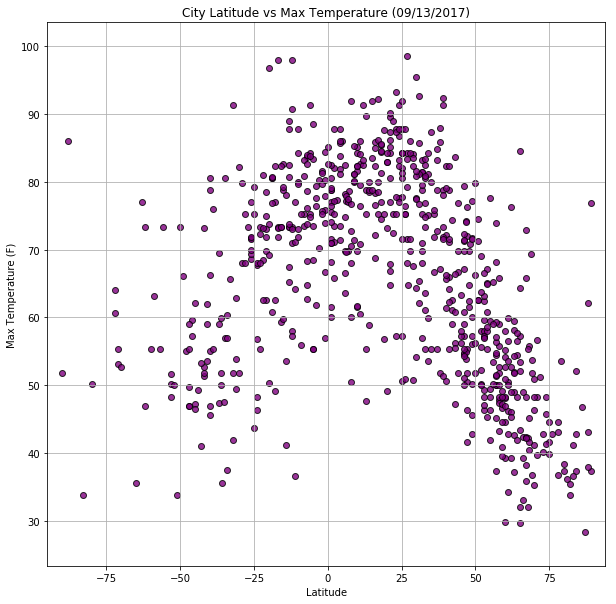

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(locations_df['Lat'],locations_df['Max Temp'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

ax.grid(True)
ax.set_title('City Latitude vs Max Temperature (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
ax.set_xlabel('Latitude')
ax.set_ylabel('Max Temperature (F)')
ax.set_xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
ax.set_ylim(locations_df['Max Temp'].min()-5, (locations_df['Max Temp'].max()+5))
plt.show()

## Latitude vs Humidity Plot

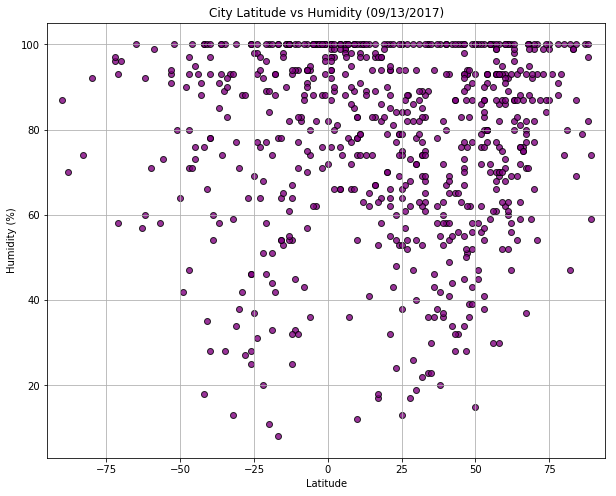

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(locations_df['Lat'],locations_df['Humidity'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

plt.grid(True)
plt.title('City Latitude vs Humidity (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
plt.ylim(locations_df['Humidity'].min()-5, (locations_df['Humidity'].max()+5))
plt.show()

## Latitude vs Cloudiness Plot

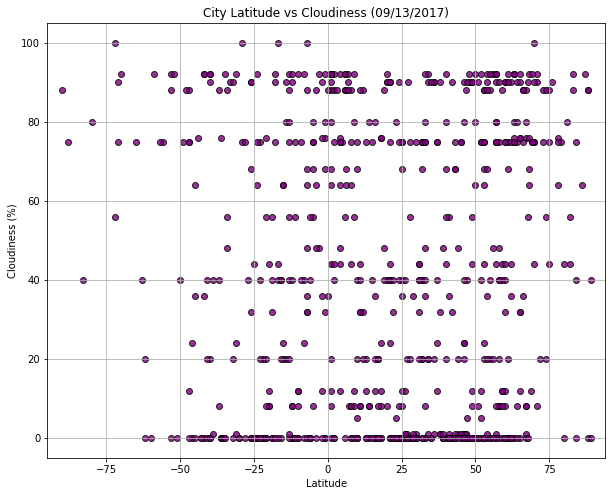

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(locations_df['Lat'],locations_df['Cloudiness'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

plt.grid(True)
plt.title('City Latitude vs Cloudiness (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
plt.ylim(locations_df['Cloudiness'].min()-5, (locations_df['Cloudiness'].max()+5))
plt.show()

## Latitude vs Wind Speed Plot

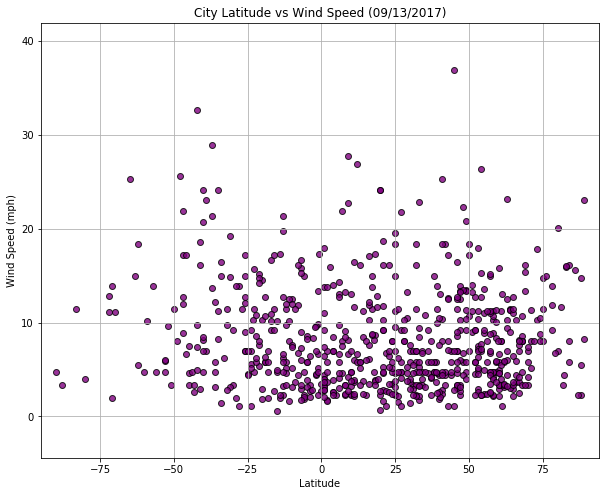

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(locations_df['Lat'],locations_df['Wind Speed'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

plt.grid(True)
plt.title('City Latitude vs Wind Speed (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
plt.ylim(locations_df['Wind Speed'].min()-5, (locations_df['Wind Speed'].max()+5))
plt.show()